# 1. Import library 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, SimpleRNN, LSTM, Dropout, RepeatVector, TimeDistributed, Activation, Flatten, MaxPooling2D
from tensorflow.keras import optimizers

In [2]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import pandas as pd
import datetime
import time
from arch import arch_model #traditional financial data analysis functions
import matplotlib.pyplot as plt
#from numba import jit
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import read_csv
import time
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [3]:
X=pd.read_csv("Data preprocess/x_columns_removed.csv",header=0, index_col=0)
y=pd.read_csv("Data preprocess/y_columns_removed.csv",header=0, index_col=0)
y=pd.DataFrame(y["Inflation"])
X=X.iloc[:-40]
y=y.iloc[:-40]
y

,Inflation
sasdate,
1962-01-09,0.461286
1962-01-10,-0.131579
1962-01-11,0.000000
1962-01-12,0.000000
1963-01-01,0.197304
...,...
2019-01-09,0.176366
2019-01-10,0.285350
2019-01-11,0.217068


# PCA

In [4]:
n=[]
var_explained=[]
for n_comp in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,100,120,123]:

    steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = n_comp, random_state=1))]
    
    pl_pca_X = Pipeline(steps_X)
    X_pca_model = pl_pca_X.fit(X)
    n.append(n_comp)
    var_explained.append(X_pca_model.steps[1][1].explained_variance_ratio_.sum())
    print('n_components:', n_comp, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

PCA(n_components = 20, random_state=1)

n_components: 1    variance explained: 0.150
n_components: 2    variance explained: 0.224
n_components: 3    variance explained: 0.295
n_components: 4    variance explained: 0.352
n_components: 5    variance explained: 0.395
n_components: 6    variance explained: 0.430
n_components: 7    variance explained: 0.460
n_components: 8    variance explained: 0.484
n_components: 9    variance explained: 0.506
n_components: 10    variance explained: 0.526
n_components: 11    variance explained: 0.545
n_components: 12    variance explained: 0.563
n_components: 13    variance explained: 0.579
n_components: 14    variance explained: 0.595
n_components: 15    variance explained: 0.611
n_components: 16    variance explained: 0.625
n_components: 17    variance explained: 0.639
n_components: 18    variance explained: 0.653
n_components: 19    variance explained: 0.666
n_components: 20    variance explained: 0.678
n_components: 30    variance explained: 0.781
n_components: 50    variance explained: 0.9

PCA(n_components=20, random_state=1)

In [5]:
steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('pca', PCA(n_components = 40, random_state=1))]

pl_pca_X = Pipeline(steps_X)

X_pca_model = pl_pca_X.fit(X)

print('n_components:', 40, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

X_pca = X_pca_model.transform(X)

n_components: 40    variance explained: 0.855


In [6]:
X_pca

array([[ 0.22167777, -2.96001911, -0.71976557, ..., -0.16200415,
        -0.1053105 ,  0.69344674],
       [-1.92653097, -1.8090885 , -1.31534188, ...,  1.24753263,
        -0.26756103,  0.10909445],
       [ 0.17108903,  5.06573426,  3.44371259, ..., -0.00908033,
        -1.72819292, -0.05070216],
       ...,
       [ 3.38777028, -2.10490861,  0.94898482, ...,  0.30509824,
         0.43082889,  0.11743929],
       [-1.61336374,  1.45124177, -0.86898696, ...,  1.11127073,
         0.35786063, -0.70929172],
       [ 1.6416219 , -1.79705155, -0.31196226, ...,  0.24262987,
         0.3352381 , -0.51599402]])

# Training Model

In [7]:
train_ratio=0.3
n = int(len(X)*train_ratio)
n_steps = 12
n_features = X_pca.shape[1]


In [8]:
# split a multivariate sequence into samples
def split_sequences(X, n_steps):
    X_seq = list()
    for i in range(len(X)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(X):
            break
        # gather input and output parts of the pattern
        seq_x = X[i:end_ix, :]
        X_seq.append(seq_x)
    return np.array(X_seq)

In [9]:
X_train = split_sequences(X_pca[:-n], n_steps)
#X_train = split_sequences(X.iloc[:-1], n_steps)
X_train.shape # no. of instances, no.of timesteps, no.of features

(472, 12, 40)

In [10]:
y_train = y.iloc[n_steps:-n+1].values
#y_train = y.iloc[n_steps:].values
y_train


array([[-0.0976086 ],
       [ 0.0976086 ],
       [ 0.09751342],
       [ 0.32435967],
       [ 0.194112  ],
       [-0.0970089 ],
       [ 0.0970089 ],
       [ 0.0323154 ],
       [ 0.09688359],
       [ 0.09678981],
       [ 0.03224246],
       [ 0.09666506],
       [ 0.09657171],
       [ 0.12861738],
       [ 0.2887857 ],
       [ 0.12808199],
       [ 0.09595395],
       [ 0.        ],
       [ 0.09586197],
       [ 0.2233212 ],
       [ 0.31816762],
       [ 0.41211027],
       [-0.09495174],
       [-0.09504198],
       [ 0.22162428],
       [ 0.09483168],
       [ 0.31545767],
       [ 0.31446567],
       [ 0.09414719],
       [ 0.62539291],
       [ 0.31123586],
       [ 0.31027018],
       [ 0.21661775],
       [ 0.09269273],
       [ 0.21594949],
       [ 0.61444126],
       [ 0.30581064],
       [ 0.30487828],
       [ 0.09128253],
       [ 0.12158056],
       [-0.0607718 ],
       [ 0.30349037],
       [ 0.        ],
       [ 0.30257209],
       [ 0.        ],
       [ 0

In [11]:
X_test = split_sequences(X_pca[-n-n_steps+1:], n_steps)
#X_test = split_sequences(X.iloc[-n-n_steps+1:], n_steps)
X_test.shape

(206, 12, 40)

15/15 [==============================] - 0s 3ms/step
test error:  0.3596511270307449
train error 0.08251955212990747
Correlation:            Actual      LSTM
Actual  1.000000  0.032142
LSTM    0.032142  1.000000
R2:  -0.4378151161583457


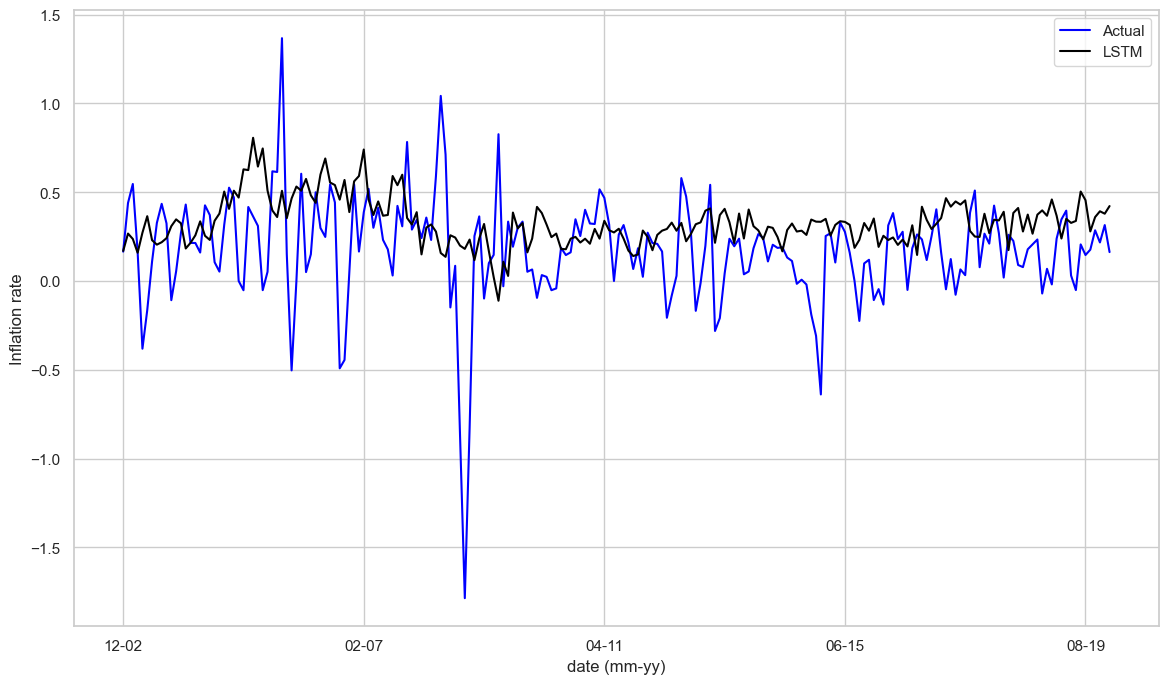

In [12]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape
LSTM_train_pred = model.predict(X_train)

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("test error: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("train error", metrics.mean_squared_error(y.iloc[:-n-n_steps+1], LSTM_train_pred))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="blue")
(results["LSTM"]).plot(color="black")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.grid(True)
plt.show()